# Sub mm Precision

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/Precision.ipynb)

## The problem

Multiple systems exhibit sub-mm precision (i.e. precision lower than 1 mm), yet the FMCW basics is that resolution is a function of the chirp bandwidth. 

Antenna designs often limits bandwidth to sub 10-GHz which effectively limits resolution to 3 cm.


## The solution

Instead of using the frequency of the FFT bin, use a frequency estimator with higher precision. While it will not be possible to resolve two targets with better than the FFT range resolution, it will be possible to increase precision of the estimated frequency.

Small list of possible algorithms are:
* simple FFT
* FFT with zero padding
* Quinn's second interpolation [1]
* Phase based interpolation

[1] Quinn, BG, "Estimation of frequency, amplitude and phase from the DFT of a time series," IEEE Trans. Sig. Proc. Vol 45, No 3, Mar 1997, pp814-817.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt
print(datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
2024-05-23 14:08:44.193499


In [2]:
from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import arange, where, expand_dims

# uncomment below if the notebook is launched from project's root folder
# dp = abspath(join(".",pardir))
# sys.path.insert(0, dp)


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402

### Frequency Estimator for sub-mm precision

Below is just an example with nominal values. For a more comprehensive analysis, noise sensitivity (phase noise in RX channel), channel noise and other aspects would need to be considered.

For embedded systems, a zoom FFT, can be used to reduce the memory needed for the full FFT to be computed.

Overview - Comparing 

> FFT estimator ($\approx 9 mm$) 

vs 

> Quinn2 estimator ($\approx 0.4 \mu m$)


radar Range resolution: 0.0375


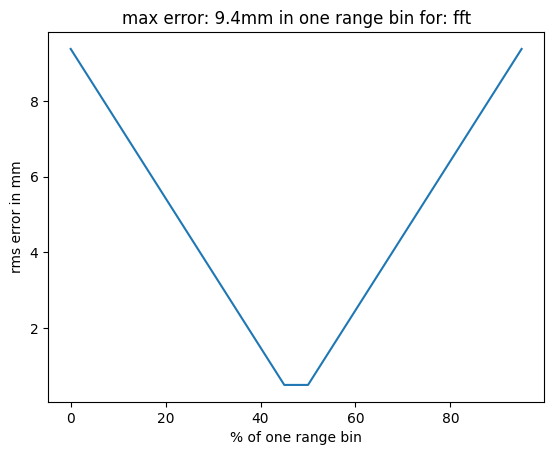

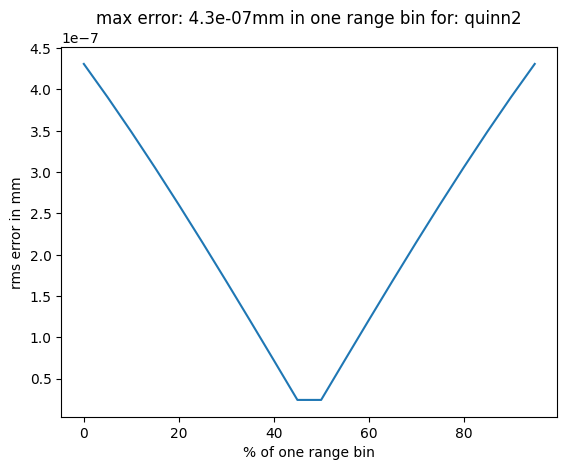

In [8]:
from numpy import linspace
from numpy import complex_ as complex

debug_ON = False
c = 3e8
test = 0
fs = 10.24e3
k = 50e8
BW = 4e9
radar = Radar(transmitter=Transmitter(bw=BW, slope=k, chirps_count=1),
              receiver=Receiver(fs=fs, max_adc_buffer_size=9000,
                                debug=debug_ON), debug=debug_ON)
delta_R = c/2/BW
print("radar Range resolution:", delta_R)
range_bin_index = 100
d_start = delta_R * (range_bin_index - 0.25)
d_end = d_start + delta_R/2
increments_count = 20
ds = linspace(d_start, d_end, increments_count)


# compare FFT to quinn2
errors = []
for est in ["fft", "quinn2"]:
    errors_in_mm = []
    deltas = []
    for idx, d1 in enumerate(ds):
        delta = idx/increments_count
        deltas.append(delta*100)

        targets = [Target(d1)]
        bb = rt_points(radar, targets, datatype=complex, debug=debug_ON)

        Distances, range_profile = rsp.range_fft(bb)
        ca_cfar = rsp.cfar_ca_1d(abs(range_profile))

        mag_r = abs(range_profile)
        mag_c = abs(ca_cfar)
        # little hack to remove small FFT ripples : mag_r> 10
        target_filter = ((mag_r > mag_c) & (mag_r > 20))

        index_peaks = where(target_filter)[0]
        # note: grouped_peaks only returns integer values
        # an improvement could be to return float values here with
        # simple interpolator
        grouped_peaks = rsp.peak_grouping_1d(index_peaks, mag_r)
        ipeaks = rsp.frequency_estimator(range_profile, grouped_peaks,
                                         estimator_name=est)
        f2d = rsp.if2d(radar)
        distances = f2d  * (radar.fs* ipeaks/radar.n_adc)
        found_targets = [Target(d) for d in distances]
        error = rsp.error(targets, found_targets)
        if error>2:
            print("errr",idx, error)
        else:
            pass
        errors_in_mm.append(error*1e3)
    max_error = max(errors_in_mm)
    errors.append(max_error)
    plt.plot(deltas, errors_in_mm)
    plt.title(f"max error: {max_error:.2g}mm in one range bin for: {est}")
    plt.xlabel('% of one range bin')
    plt.ylabel('rms error in mm')
    plt.show()

In [7]:
from numpy.testing import assert_almost_equal
print(errors[0])
print(errors[1])
assert_almost_equal(errors[0]*1e-3, 9.375e-3)
assert_almost_equal(errors[1]*1e-3, 4.309e-10)

9.375000000000355
4.308655654483573e-07
